In [263]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [264]:
!pip install pyspark

In [265]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc , col, max, struct
import matplotlib.pyplot as plt

In [266]:
spark = SparkSession.builder.appName('spark_app').getOrCreate()

# Importing the file

In [267]:
df = spark.read.csv('/content/drive/My Drive/Seattle/Data-Collisions.csv', inferSchema=True, header=True)

# Analysing the data sets

In [268]:
shape = (df.count(), len(df.columns))
print(shape)
df.show()

(194673, 38)
+-------------+------------+-----------+--------+------+---------+--------+---------+------------+------+--------------------+-------------+-------------+--------------+--------------------+-------------+-----------+--------+-----------+--------+--------------------+--------------------+--------------------+------------+--------------------+--------------+---------+--------+--------+--------------------+-------------+----------+--------+----------+--------------------+----------+------------+------------+
|SEVERITYCODE0|           X|          Y|OBJECTID|INCKEY|COLDETKEY|REPORTNO|   STATUS|    ADDRTYPE|INTKEY|            LOCATION|EXCEPTRSNCODE|EXCEPTRSNDESC|SEVERITYCODE13|        SEVERITYDESC|COLLISIONTYPE|PERSONCOUNT|PEDCOUNT|PEDCYLCOUNT|VEHCOUNT|             INCDATE|             INCDTTM|        JUNCTIONTYPE|SDOT_COLCODE|        SDOT_COLDESC|INATTENTIONIND|UNDERINFL| WEATHER|ROADCOND|           LIGHTCOND|PEDROWNOTGRNT|SDOTCOLNUM|SPEEDING|ST_COLCODE|          ST_COLDESC|SEG

In [269]:
df.printSchema()

root
 |-- SEVERITYCODE0: integer (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- OBJECTID: integer (nullable = true)
 |-- INCKEY: integer (nullable = true)
 |-- COLDETKEY: integer (nullable = true)
 |-- REPORTNO: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- ADDRTYPE: string (nullable = true)
 |-- INTKEY: integer (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- EXCEPTRSNCODE: string (nullable = true)
 |-- EXCEPTRSNDESC: string (nullable = true)
 |-- SEVERITYCODE13: integer (nullable = true)
 |-- SEVERITYDESC: string (nullable = true)
 |-- COLLISIONTYPE: string (nullable = true)
 |-- PERSONCOUNT: integer (nullable = true)
 |-- PEDCOUNT: integer (nullable = true)
 |-- PEDCYLCOUNT: integer (nullable = true)
 |-- VEHCOUNT: integer (nullable = true)
 |-- INCDATE: string (nullable = true)
 |-- INCDTTM: string (nullable = true)
 |-- JUNCTIONTYPE: string (nullable = true)
 |-- SDOT_COLCODE: integer (nullable = true)
 

In [270]:
df = df.drop('INCDATE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'COLDETKEY',
             'X', 'Y', 'SEVERITYCODE0', 'INCKEY', 'INTKEY', 'REPORTNO', 'INATTENTIONIND','PEDROWNOTGRNT', 'LOCATION', 'INCDTTM')

In [271]:
print(df.count(), len(df.columns))
df.printSchema()


194673 18
root
 |-- OBJECTID: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- ADDRTYPE: string (nullable = true)
 |-- SEVERITYCODE13: integer (nullable = true)
 |-- SEVERITYDESC: string (nullable = true)
 |-- COLLISIONTYPE: string (nullable = true)
 |-- PERSONCOUNT: integer (nullable = true)
 |-- PEDCOUNT: integer (nullable = true)
 |-- PEDCYLCOUNT: integer (nullable = true)
 |-- VEHCOUNT: integer (nullable = true)
 |-- JUNCTIONTYPE: string (nullable = true)
 |-- UNDERINFL: string (nullable = true)
 |-- WEATHER: string (nullable = true)
 |-- ROADCOND: string (nullable = true)
 |-- LIGHTCOND: string (nullable = true)
 |-- SPEEDING: string (nullable = true)
 |-- CROSSWALKKEY: integer (nullable = true)
 |-- HITPARKEDCAR: string (nullable = true)



In [272]:
#get the summary statistics
df.describe().show()

+-------+-----------------+---------+------------+-------------------+--------------------+-------------+------------------+--------------------+-------------------+------------------+--------------------+--------------------+-----------------+--------+--------------------+--------+-----------------+------------+
|summary|         OBJECTID|   STATUS|    ADDRTYPE|     SEVERITYCODE13|        SEVERITYDESC|COLLISIONTYPE|       PERSONCOUNT|            PEDCOUNT|        PEDCYLCOUNT|          VEHCOUNT|        JUNCTIONTYPE|           UNDERINFL|          WEATHER|ROADCOND|           LIGHTCOND|SPEEDING|     CROSSWALKKEY|HITPARKEDCAR|
+-------+-----------------+---------+------------+-------------------+--------------------+-------------+------------------+--------------------+-------------------+------------------+--------------------+--------------------+-----------------+--------+--------------------+--------+-----------------+------------+
|  count|           194673|   194673|      192747|     

In [273]:
df= df.dropDuplicates(['OBJECTID'])
print(df.count(), len(df.columns))

194673 18


In [274]:
#check for null values
for col in df.columns:
  print(col+":",df[df[col].isNull()].count())

OBJECTID: 0
STATUS: 0
ADDRTYPE: 1926
SEVERITYCODE13: 0
SEVERITYDESC: 0
COLLISIONTYPE: 4904
PERSONCOUNT: 0
PEDCOUNT: 0
PEDCYLCOUNT: 0
VEHCOUNT: 0
JUNCTIONTYPE: 6329
UNDERINFL: 4884
WEATHER: 5081
ROADCOND: 5012
LIGHTCOND: 5170
SPEEDING: 185340
CROSSWALKKEY: 0
HITPARKEDCAR: 0


In [275]:
df = df.drop('SPEEDING')

In [276]:
df = df.na.drop()

In [277]:
# to remove whitespace
from pyspark.sql.functions import trim
str_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
for cols in str_cols:
  df = df.withColumn(cols, trim(df[cols]))

In [278]:
q0 = df.groupBy('ADDRTYPE').count().orderBy('count',ascending=False).show()

+------------+------+
|    ADDRTYPE| count|
+------------+------+
|       Block|119362|
|Intersection| 63298|
|       Alley|   235|
+------------+------+



In [279]:
q1 = df.groupBy('ADDRTYPE', 'JUNCTIONTYPE', 'LIGHTCOND', 'WEATHER').count().orderBy('count',ascending=False).show()

+------------+--------------------+--------------------+--------+-----+
|    ADDRTYPE|        JUNCTIONTYPE|           LIGHTCOND| WEATHER|count|
+------------+--------------------+--------------------+--------+-----+
|       Block|Mid-Block (not re...|            Daylight|   Clear|33332|
|Intersection|At Intersection (...|            Daylight|   Clear|27729|
|       Block|Mid-Block (not re...|Dark - Street Lig...|   Clear|12795|
|       Block|Mid-Block (but in...|            Daylight|   Clear| 9785|
|Intersection|At Intersection (...|Dark - Street Lig...|   Clear| 8032|
|       Block|Mid-Block (not re...|            Daylight|Overcast| 7161|
|       Block|Mid-Block (not re...|            Daylight| Raining| 6753|
|       Block|Mid-Block (not re...|             Unknown| Unknown| 6417|
|Intersection|At Intersection (...|            Daylight| Raining| 6376|
|Intersection|At Intersection (...|            Daylight|Overcast| 6246|
|       Block|Mid-Block (not re...|Dark - Street Lig...| Raining

In [280]:
print(str_cols)

['STATUS', 'ADDRTYPE', 'SEVERITYDESC', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'HITPARKEDCAR']


In [281]:
# ! pip install handyspark
from handyspark import *
hdf = df.toHandy()

In [282]:
# calculating the correlation for int cols
print(hdf.corr('SEVERITYCODE13', 'PERSONCOUNT'))
print(hdf.corr('SEVERITYCODE13', 'VEHCOUNT'))
print(hdf.corr('SEVERITYCODE13', 'PEDCOUNT'))
print(hdf.corr('SEVERITYCODE13', 'PEDCYLCOUNT'))
print(hdf.corr('SEVERITYCODE13', 'CROSSWALKKEY'))

0.12454450872538565
-0.0811655902556576
0.2456563501983892
0.21404334955438414
0.17451333979915673


# data visualization

In [283]:
df.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- ADDRTYPE: string (nullable = true)
 |-- SEVERITYCODE13: integer (nullable = true)
 |-- SEVERITYDESC: string (nullable = true)
 |-- COLLISIONTYPE: string (nullable = true)
 |-- PERSONCOUNT: integer (nullable = true)
 |-- PEDCOUNT: integer (nullable = true)
 |-- PEDCYLCOUNT: integer (nullable = true)
 |-- VEHCOUNT: integer (nullable = true)
 |-- JUNCTIONTYPE: string (nullable = true)
 |-- UNDERINFL: string (nullable = true)
 |-- WEATHER: string (nullable = true)
 |-- ROADCOND: string (nullable = true)
 |-- LIGHTCOND: string (nullable = true)
 |-- CROSSWALKKEY: integer (nullable = true)
 |-- HITPARKEDCAR: string (nullable = true)



In [284]:
import matplotlib.pyplot as plt

In [285]:
cols = ['ADDRTYPE','WEATHER','JUNCTIONTYPE', 'VEHCOUNT','LIGHTCOND', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'ROADCOND', 'SEVERITYCODE13','PEDCOUNT', 
        'UNDERINFL','PEDCYLCOUNT', 'OBJECTID']
viz_1 = df.select(cols).toPandas()

In [286]:
hdf.cols['JUNCTIONTYPE'].value_counts()

JUNCTIONTYPE
At Intersection (but not related to intersection)     2055
At Intersection (intersection related)               61206
Driveway Junction                                    10519
Mid-Block (but intersection related)                 22341
Mid-Block (not related to intersection)              86609
Ramp Junction                                          160
Unknown                                                  5
Name: value_counts, dtype: int64

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

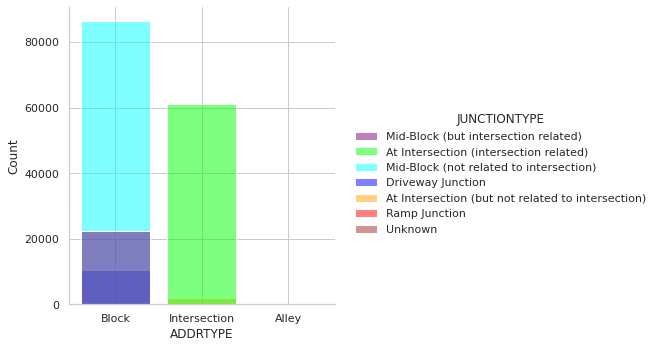

In [287]:
color_status_1 = {'At Intersection (but not related to intersection)': 'orange', 'At Intersection (intersection related)': 'lime',
                'Driveway Junction': 'blue', 'Mid-Block (but intersection related)': 'purple', 'Mid-Block (not related to intersection)': 'cyan',
                'Ramp Junction': 'red', 'Unknown': 'brown'}
sns.displot(x='ADDRTYPE',hue='JUNCTIONTYPE', data=viz_1, palette=color_status_1, bins=3, shrink=.8)
plt.xticks(rotation=0)
#plt.legend(loc='upper right')

In [288]:
hdf.cols['LIGHTCOND'].value_counts()

LIGHTCOND
Dark - No Street Lights       1461
Dark - Street Lights Off      1157
Dark - Street Lights On      47547
Dark - Unknown Lighting         11
Dawn                          2453
Daylight                    113837
Dusk                          5771
Other                          210
Unknown                      10448
Name: value_counts, dtype: int64

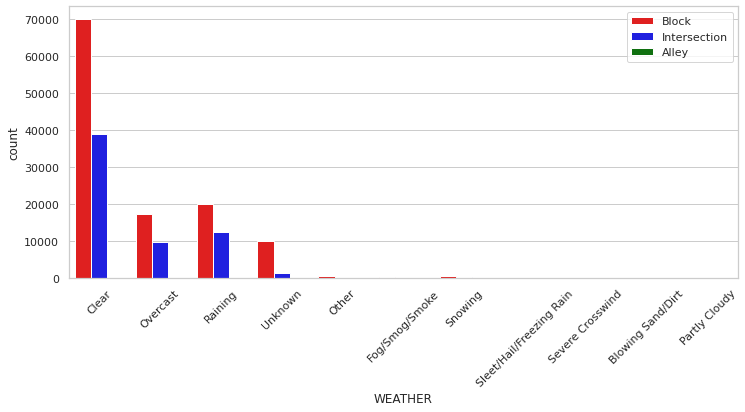

In [289]:
import seaborn as sns
color_status = {'Alley': 'green', 'Block': 'red', 'Intersection': 'blue'}
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x='WEATHER', hue='ADDRTYPE', data=viz_1, ax=ax, palette=color_status)
plt.xticks(rotation=45)
plt.legend(loc='upper right')

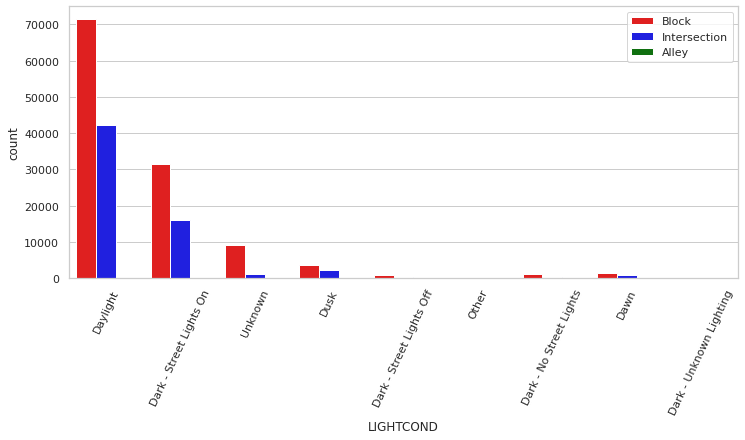

In [290]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x='LIGHTCOND', hue='ADDRTYPE', data=viz_1, ax=ax, palette=color_status)
plt.xticks(rotation=65)
plt.legend(loc='upper right')

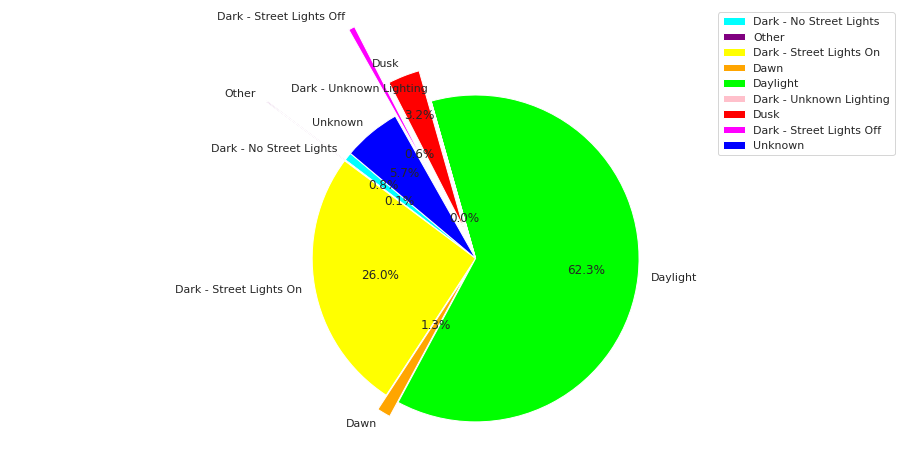

In [291]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Dark - No Street Lights', 'Other', 'Dark - Street Lights On', 'Dawn', 'Daylight','Dark - Unknown Lighting', 'Dusk', 'Dark - Street Lights Off', 'Unknown'
sizes = [0.7988, 0.11, 25.99, 1.34, 62.24, 0.0061, 3.15, 0.6326, 5.71]
explode = (0, 0.3, 0, 0.05, 0, 0, 0.1, 0.3, 0)
colors=('cyan', 'purple', 'yellow', 'orange', 'lime', 'pink', 'red', 'magenta', 'blue')
fig1, ax1 = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))
w, l, p = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=140, pctdistance=0.85, labeldistance=1.079, radius=0.5, colors=colors)
pctdists = [.85, .4, .7, .5, .8, .3, .9, .5, .8]
for t,d in zip(p, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()

In [292]:
hdf.cols['SEVERITYDESC'].value_counts()

SEVERITYDESC
Injury Collision                   56625
Property Damage Only Collision    126270
Name: value_counts, dtype: int64

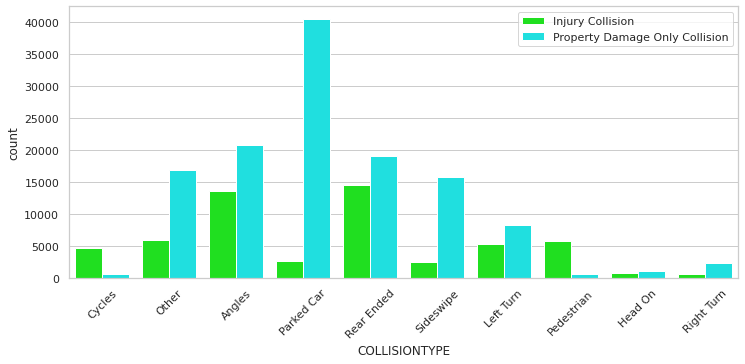

In [293]:
color_status_2 = {'Injury Collision': 'lime', 'Property Damage Only Collision': 'cyan'}
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x='COLLISIONTYPE', hue='SEVERITYDESC', data=viz_1, ax=ax, palette=color_status_2)
plt.xticks(rotation=45)
plt.legend(loc='upper right')

In [294]:
hdf.cols['ROADCOND'].value_counts()

ROADCOND
Dry               122153
Ice                 1177
Oil                   60
Other                123
Sand/Mud/Dirt         67
Snow/Slush           978
Standing Water       108
Unknown            11519
Wet                46710
Name: value_counts, dtype: int64

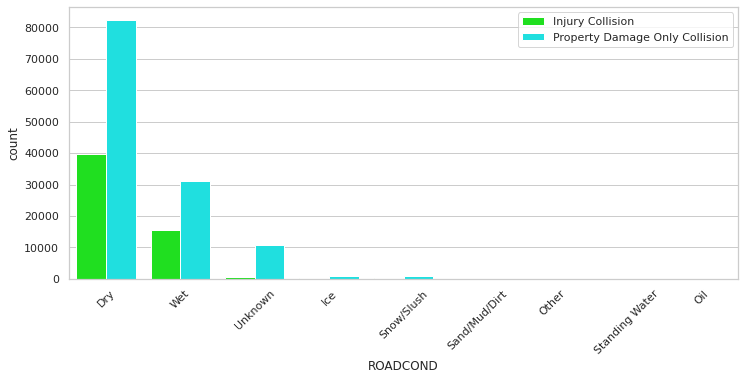

In [295]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x='ROADCOND', hue='SEVERITYDESC', data=viz_1, ax=ax, palette=color_status_2)
plt.xticks(rotation=45)
plt.legend(loc='upper right')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


<Figure size 1152x576 with 0 Axes>

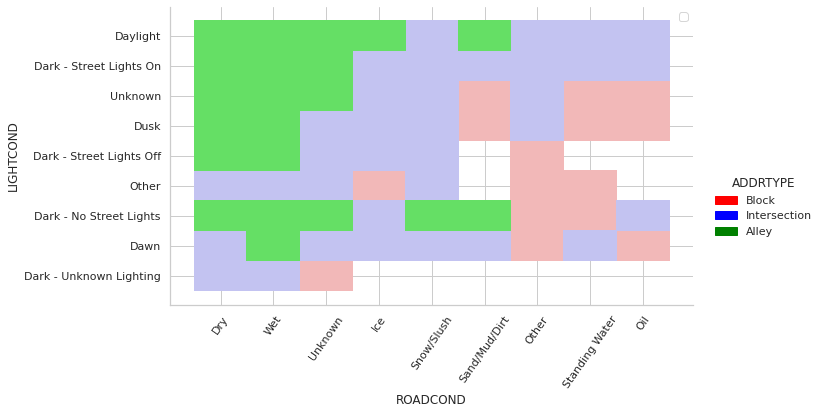

In [296]:
plt.figure(figsize=(16,8))
sns.displot(x='ROADCOND', y='LIGHTCOND', hue='ADDRTYPE', data=viz_1, ax=ax, palette=color_status, aspect=2)
plt.xticks(rotation=55)
plt.legend(loc="upper right")

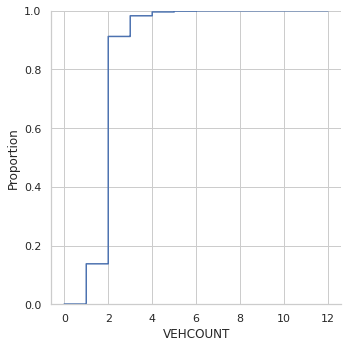

In [297]:
sns.displot(data=viz_1, x="VEHCOUNT", kind="ecdf")

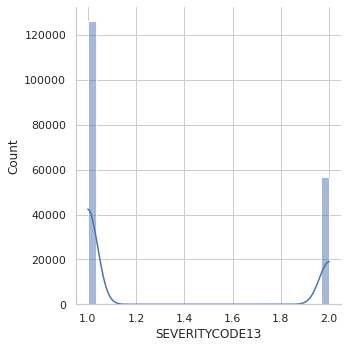

In [298]:
sns.displot(data=viz_1, x="SEVERITYCODE13", kde=True, height=5, aspect=1)

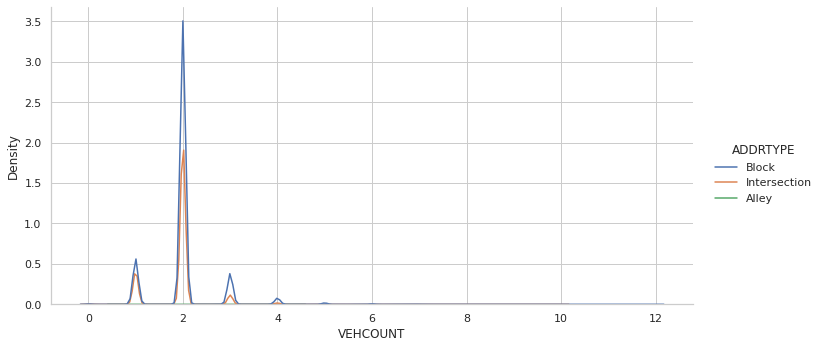

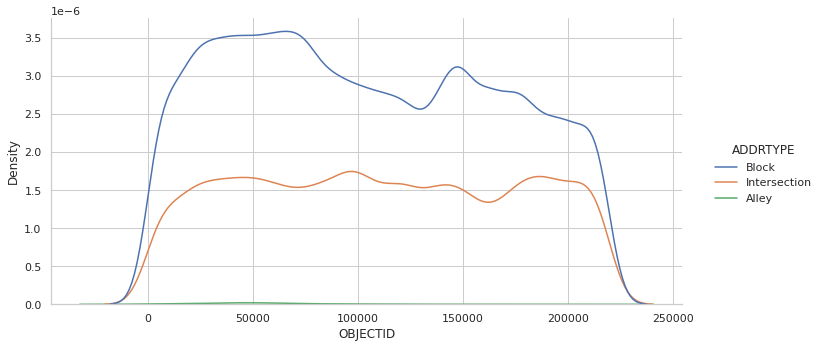

In [299]:
sns.displot(data=viz_1, x="VEHCOUNT", hue="ADDRTYPE", kind="kde", height=5, aspect=2)
sns.displot(data=viz_1, x="OBJECTID", hue="ADDRTYPE", kind="kde", height=5, aspect=2)

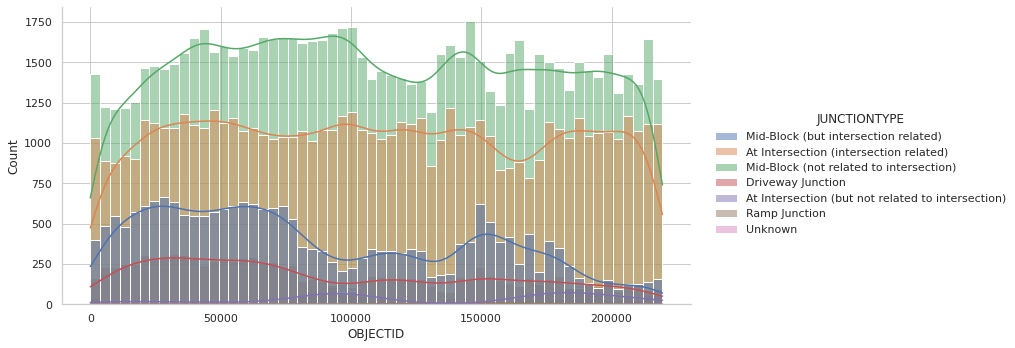

In [300]:
sns.displot(data=viz_1, x="OBJECTID", hue="JUNCTIONTYPE", kde=True, height=5, aspect=2)

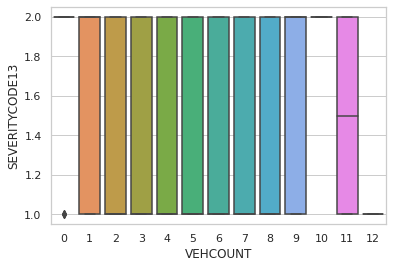

In [301]:
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x=viz_1["VEHCOUNT"], y=viz_1["SEVERITYCODE13"], orient='v')

In [302]:
hdf.cols['COLLISIONTYPE'].value_counts()

COLLISIONTYPE
Angles        34453
Cycles         5362
Head On        1996
Left Turn     13637
Other         22960
Parked Car    43119
Pedestrian     6513
Rear Ended    33641
Right Turn     2929
Sideswipe     18285
Name: value_counts, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


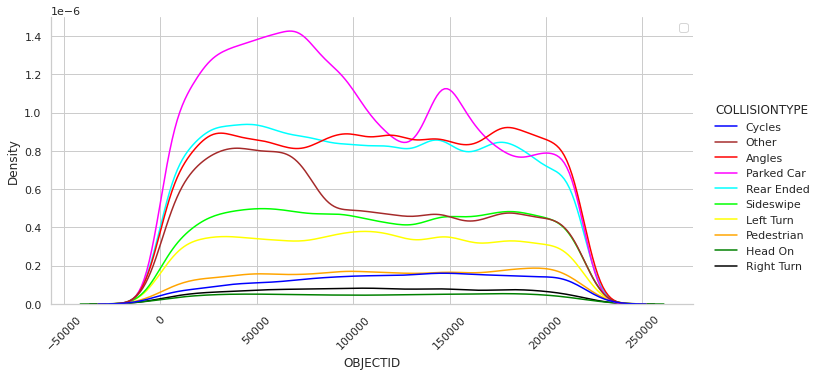

In [303]:
color_status_3 = {'Angles': 'red', 'Cycles': 'blue', 'Head On': 'green', 'Left Turn': 'yellow', 
                  'Other': 'brown', 'Parked Car': 'magenta', 'Pedestrian': 'orange', 'Rear Ended': 'cyan',
                  'Right Turn': 'black', 'Sideswipe': 'lime'}
sns.displot(x='OBJECTID', hue='COLLISIONTYPE', data=viz_1, ax=ax, palette=color_status_3, aspect=2, kind="kde")
plt.xticks(rotation=45)
plt.legend(loc='upper right')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


<Figure size 1152x576 with 0 Axes>

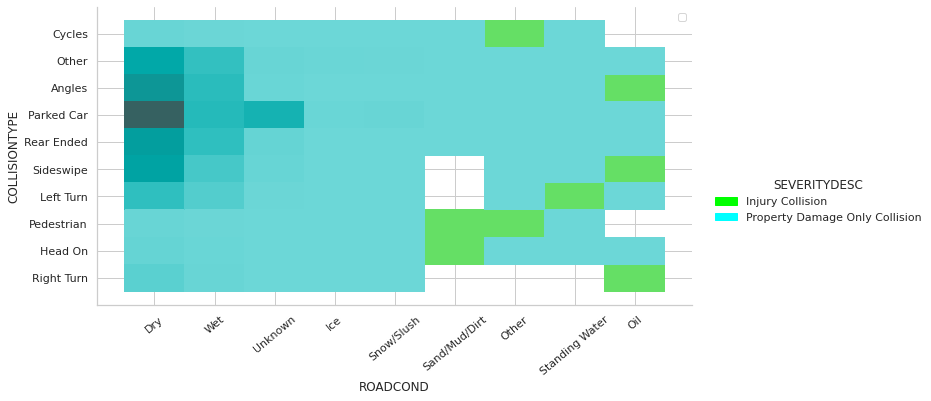

In [304]:
plt.figure(figsize=(16,8))
sns.displot(x='ROADCOND', y='COLLISIONTYPE', hue='SEVERITYDESC', data=viz_1, ax=ax, palette=color_status_2, aspect=2)
plt.xticks(rotation=40)
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


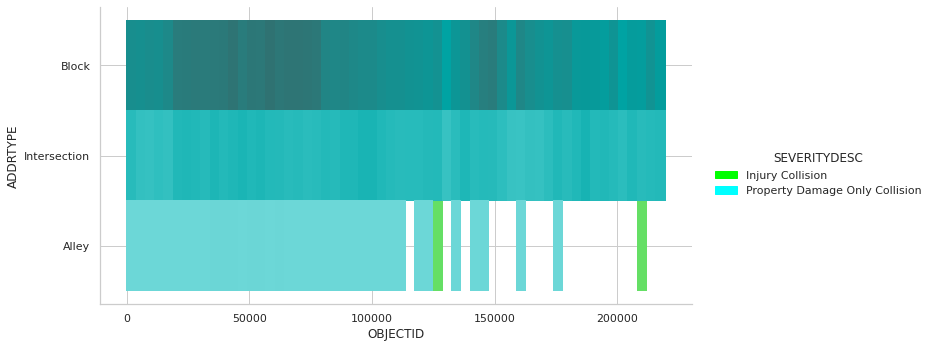

In [305]:
sns.displot(x='OBJECTID', y='ADDRTYPE', hue='SEVERITYDESC', data=viz_1, ax=ax, palette=color_status_2, aspect=2)

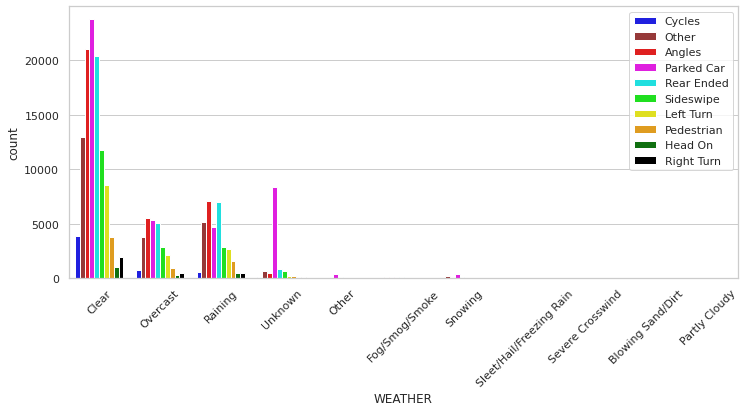

In [314]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x='WEATHER', hue='COLLISIONTYPE', data=viz_1, ax=ax, palette=color_status_3)
plt.xticks(rotation=45)
plt.legend(loc='upper right')

In [308]:
# printing out this,to know what no. of personcounts are most frequent
hdf.cols['PERSONCOUNT'].value_counts()

PERSONCOUNT
0       5365
1      11232
2     105703
3      34812
4      14327
5       6541
6       2686
7       1121
8        531
9        213
10       127
11        56
12        33
13        21
14        19
15        11
16         8
17        11
18         6
19         5
20         6
21         2
22         4
23         2
24         2
25         6
26         4
27         3
28         3
29         3
30         2
31         1
32         3
34         3
35         1
36         2
37         3
39         1
41         1
43         1
44         6
47         3
48         1
53         1
54         1
57         1
81         1
Name: value_counts, dtype: int64

In [307]:
hdf.cols['PEDCYLCOUNT'].value_counts()

PEDCYLCOUNT
0    177480
1      5374
2        41
Name: value_counts, dtype: int64